# Compare LINEAR and ZTF light curves

### Perform statistical tests and visual analysis to seek evidence for the Blazhko effect:

1) read LINEAR data

2) pick a star using LINEAR ID

3) retrieve ZTF gri data 

4) compute periods using separately LINEAR and ZTF data (gri average for the latter)

5) compute the mean period 

6) compare periods from 4) and 5)

7) compare light curve amplitudes and shapes from 4) and 5)

In [23]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import norm
np.random.seed(42)
%matplotlib inline  

In [24]:
from astroML.utils.decorators import pickle_results
from astroML.datasets import fetch_LINEAR_sample
from astropy.table import Table
from ztfquery import lightcurve
from astropy.timeseries import LombScargle
from astroML.time_series import MultiTermFit

## some helper routines and wrappers...

In [25]:
def getCoordinatesFromLINEARid(tbl, id0):
    return tbl[tbl['ID'].astype(str)==id0]['ra'][0], tbl[tbl['ID'].astype(str)==id0]['dec'][0]

# retrieve ZTF data for a single object specified by (RA, Dec)
def getZTFlightcurve(ra, dec, radius=3.0):
    # matching radius is given in arcsec
    try:
       lcq = lightcurve.LCQuery()
       res = lcq.from_position(ra, dec, radius)
       ZTFdata = res.data # this is basically a DataFrame then
       # M. Graham recommends to get rid of obvious spurious points
       ZTFdata = ZTFdata.loc[ZTFdata['catflags'] < 32768]
    except Exception as e:
       print(e)
    return ZTFdata

# a little helper: sort array a, and reorder b, c, too. 
def sort3arr(a, b, c):
    ind = np.argsort(a)
    return a[ind], b[ind], c[ind]

def sigG(x):
    return 0.741*(np.percentile(x,75)-np.percentile(x,25))

In [26]:
# wrapper around LombScargle: given light curve data (time, mag, magErr)
# compute period using nterms Fourier terms
# return best period and power spectrum: LSpower(frequency) is lsPS=True
# note: period (days) = 1. / frequency
def doPeriodsOrig(time, mag, magErr, nterms, lsPS=False, nyquist=300):
    try:
        ls = LombScargle(time, mag, magErr, nterms=nterms) # set up a LombScargle object to model the frequency and power
        if (1):
            frequency, power = ls.autopower(nyquist_factor=nyquist) # calculate the frequency and power
        else:
            frequency = np.arange(0.4, 40, 0.2e-04)
            power = ls.power(frequency)  
        period = 1. / frequency # calculating the periods
        best_period = period[np.argmax(power)] # choosing the period with the highest power
        if lsPS: 
            return best_period, frequency, power
        else:
            return best_period
    except:
        print('failed for ID=', Lid)
        return 'Error in doPeriods'

# similar to doPeriodsOrig(), but first try with auto frequency grid
# and then "zoom-in" around the highest LS power peak 
# note: freqFac=1.02 allows search for Blazhko periods longer than 50*basic period, so ~25 days and longer
def doPeriods(time, mag, magErr, nterms, lsPS=False, nyquist=100, freqFac=1.02):
    try:
        ls = LombScargle(time, mag, magErr, nterms=nterms) # set up a LombScargle object to model the frequency and power
        frequencyAuto, powerAuto = ls.autopower(nyquist_factor=nyquist) # calculate the frequency and power
        best_freq = frequencyAuto[np.argmax(powerAuto)]
        frequency = np.arange(best_freq/freqFac, best_freq*freqFac, 5e-6)
        power = ls.power(frequency)  # compute LS periodogram again
        period = 1. / frequency
        best_period = period[np.argmax(power)] # choosing the period with the highest power
        if lsPS: 
            return best_period, frequency, power
        else:
            return best_period
    except:
        print('failed for ID=', Lid)
        return 'Error in doPeriods'

    
# further wrapping a few steps to average ZTF periods   
def getZTFperiod(ZTFdata, nterms, ZTFbands=['zg', 'zr', 'zi'], lsPS=False, nyquist=300, orig=False):
    try:
        ZTFperiods = []
        for b in ZTFbands:
            BandData = ZTFdata.loc[ZTFdata['filtercode'] == b]
            timeZ = BandData['mjd']
            magZ = BandData['mag']
            magErrZ = BandData['magerr']
            if lsPS:
                try:
                    if (orig):
                        ZTFperiod, Zfreq, Zpow = doPeriodsOrig(timeZ, magZ, magErrZ, nterms, lsPS=lsPS)
                    else:
                        ZTFperiod, Zfreq, Zpow = doPeriods(timeZ, magZ, magErrZ, nterms, lsPS=lsPS)
                    ZTFperiods.append(ZTFperiod)
                except:
                    ZTFperiod = -9.99
                    print('failed for band', b, 'Ndata=', np.size(timeZ))
            else:
                ZTFperiods.append(doPeriods(timeZ, magZ, magErrZ, nterms))
        ZTFbestPeriod = np.median(ZTFperiods)
        if lsPS:
            return ZTFbestPeriod, Zfreq, Zpow
        else:
            return ZTFbestPeriod
    except:
        print('failed: error in getZTFperiod') 
        return 'Error in getZTFperiod'

In [27]:
# given (time, mag, magErr) data, and some period P, 
# return various results of light curve analysis:
# 
def LCanalysisFromP(time, mag, magErr, P, ntermsModels):
    LCanalysisResults = {}
    # first compute best-fit models for given period
    mtf = MultiTermFit(2*np.pi/P, ntermsModels)
    mtf.fit(time, mag, magErr)
    a, b, c = mtf.predict(1000, return_phased_times=True, adjust_offset=False)
    LCanalysisResults['modelPhaseGrid'] = a
    LCanalysisResults['modelFit'] = b
    LCanalysisResults['dataPhasedTime']= c
    # light curve template normalization: mag = A * t(phi) + mmax, where
    # phi is phase, t is template, A is amplitude and mmax is the magnitude at 
    #       maximum light (note: numerically it is the minimum value of mag)
    # also: we are using models for computing amplitude and mmax to avoid noise in data
    A = np.max(b) - np.min(b) 
    mmax = np.min(b) 
    LCanalysisResults['A'] = A
    LCanalysisResults['mmax'] = mmax
    LCanalysisResults['modTemplate'] = (b - mmax)/A 
    LCanalysisResults['dataTemplate'] = (mag - mmax)/A 
    LCanalysisResults['dataTemplateErr'] = magErr/A 
    # for chi2, first interpolate model fit to phases of data values
    modelFit2data = np.interp(c, a, LCanalysisResults['modTemplate'])
    LCanalysisResults['modelFit2data'] = modelFit2data 
    delmag = LCanalysisResults['dataTemplate'] - modelFit2data
    LCanalysisResults['rms'] = sigG(delmag)
    LCanalysisResults['chi'] = delmag/LCanalysisResults['dataTemplateErr']
    LCanalysisResults['chi2dof'] = np.sum(LCanalysisResults['chi']**2)/np.size(LCanalysisResults['chi'])
    LCanalysisResults['chi2dofR'] = sigG(LCanalysisResults['chi'])
    return LCanalysisResults 

In [28]:
# L1 = LINEAR_Plinear
# L2 = LINEAR_Pmean
# Z1 = ZTF_Pztf
# Z2 = ZTF_Pmean
# 
def makeLCplot4(L1, L2, Z1, Z2, plotrootname='LCplot4', plotSave=False):
    fig, axs = plt.subplots(2,2, figsize=(14,10))  

    ### LINEAR plots
    ## TOP LEFT: with best-fit LINEAR period
    axs[0,0].set(xlabel='data phased with best-fit LINEAR period', ylabel='LINEAR normalized light curve')
    axs[0,0].set_xlim(-0.1, 1.1)
    axs[0,0].set_ylim(1.3, -0.3)
    # data
    xx, yy, zz = sort3arr(L1['dataPhasedTime'], L1['dataTemplate'], L1['dataTemplateErr'])
    axs[0,0].errorbar(xx, yy, zz, fmt='.k', ecolor='gray', lw=1, ms=4, capsize=1.5, alpha=0.3)
    # fit for Plinear
    axs[0,0].plot(L1['modelPhaseGrid'], L1['modTemplate'], 'black', markeredgecolor='black', lw=2, fillstyle='top', linestyle='solid')
    # fit for mean period
    axs[0,0].plot(L2['modelPhaseGrid'], L2['modTemplate'], 'red', markeredgecolor='red', lw=2, fillstyle='top', linestyle='solid')

    ## TOP RIGHT: with the mean period
    axs[0,1].set(xlabel='data phased with the mean period', ylabel='LINEAR normalized light curve')
    axs[0,1].set_xlim(-0.1, 1.1)
    axs[0,1].set_ylim(1.3, -0.3)
    # data
    xx, yy, zz = sort3arr(L2['dataPhasedTime'], L2['dataTemplate'], L2['dataTemplateErr'])
    axs[0,1].errorbar(xx, yy, zz, fmt='.r', ecolor='gray', lw=1, ms=4, capsize=1.5, alpha=0.3)
    # fit for mean period
    axs[0,1].plot(L2['modelPhaseGrid'], L2['modTemplate'], 'red', markeredgecolor='red', lw=2, fillstyle='top', linestyle='solid')
    
    
    ### ZTF plots
    ## BOTTOM LEFT: with best-fit ZTF period
    axs[1,0].set(xlabel='data phased with best-fit ZTF period', ylabel='ZTF normalized light curve')
    axs[1,0].set_xlim(-0.1, 1.1)
    axs[1,0].set_ylim(1.3, -0.3)
    # data
    xx, yy, zz = sort3arr(Z1['dataPhasedTime'], np.array(Z1['dataTemplate']), np.array(Z1['dataTemplateErr']))
    axs[1,0].errorbar(xx, yy, zz, fmt='.k', ecolor='gray', lw=1, ms=4, capsize=1.5, alpha=0.3)
    # fit for Pztf
    axs[1,0].plot(Z1['modelPhaseGrid'], Z1['modTemplate'], 'black', markeredgecolor='black', lw=2, fillstyle='top', linestyle='solid')
    # fit for mean period
    axs[1,0].plot(Z2['modelPhaseGrid'], Z2['modTemplate'], 'red', markeredgecolor='red', lw=2, fillstyle='top', linestyle='solid')

    ## BOTTOM RIGHT: with the mean period
    axs[1,1].set(xlabel='data phased with the mean period', ylabel='ZTF normalized light curve')
    axs[1,1].set_xlim(-0.1, 1.1)
    axs[1,1].set_ylim(1.3, -0.3)
    # data
    xx, yy, zz = sort3arr(Z2['dataPhasedTime'], np.array(Z2['dataTemplate']), np.array(Z2['dataTemplateErr']))
    axs[1,1].errorbar(xx, yy, zz, fmt='.r', ecolor='gray', lw=1, ms=4, capsize=1.5, alpha=0.3)
    # fit for mean period
    axs[1,1].plot(Z2['modelPhaseGrid'], Z2['modTemplate'], 'red', markeredgecolor='red', lw=2, fillstyle='top', linestyle='solid')
    
    if plotSave:
        plotName = plotrootname + '.png'
        plt.savefig(plotName, dpi=600)
        print('saved plot as:', plotName) 
    plt.show()     
    return


In [29]:
def compareLINEARvsZTFlightCurves(LINEARmetadata, LINEARlightcurves, LINEARid, plot=True, verbose=True):
    # for returning analysis results
    PeriodComparison = {}
    # for later assertions and sanity checks...
    PeriodComparison['LINEARid'] = LINEARid
    if verbose:
        print('------------------------------------------------------------')
        print('Period and light curve analysis for LINEAR ID =', LINEARid)
    ### first prepare light curve data
    # LINEAR light curve for this star (specified by provided LINEARid)
    tL, mL, mLerr = LINEARlightcurves[id0].T
    # get coordinates needed for ZTF data download
    ra, dec = getCoordinatesFromLINEARid(LINEARmetadata, LINEARid)
    ## instead of downloading, this could be read from Ema's new ZTF files...
    ZTFdata = getZTFlightcurve(ra, dec)

    ### now compute periods (using LombScargle from astropy.timeseries)
    nterms = 3
    # LINEAR-only period
    if verbose:
        print('  computing LINEAR period...')
    Plinear, fL, pL = doPeriods(tL, mL, mLerr, nterms, lsPS=True)
    
    # for ZTF, we'll average periods from the three (gri) filters
    if verbose:
        print('  computing ZTF period...')
    Pztf, fZ, pZ = getZTFperiod(ZTFdata, nterms, ZTFbands=['zg', 'zr', 'zi'], lsPS=True)
    # mean period, approximately equal to best fit for all data
    Pmean = (Plinear+Pztf)/2
    Pratio = Pztf/Plinear
    if verbose:
        print('Plinear=', Plinear, 'Pztf=', Pztf, 'Pmean=', Pmean, 'Pratio=', Pratio)
    PeriodComparison['Plinear'] = Plinear
    PeriodComparison['Pztf'] = Pztf
    PeriodComparison['Pratio'] = Pratio
    
    ### period and chi2 analysis
    # evaluate phased light curves and compute chi2 for models obtained using both periods:
    #    the best-fit period for each survey, and the mean period
    # compute models (now can take more Fourier terms than when computing period)
    ntermsModels = 6
    # first LINEAR light curve
    LINEAR_Plinear = LCanalysisFromP(tL, mL, mLerr, Plinear, ntermsModels)
    LINEAR_Pmean = LCanalysisFromP(tL, mL, mLerr, Pmean, ntermsModels)
    if verbose:
        print(' LINEAR light curve analysis:')
        print('  Nlinear=', np.size(tL), 'rms mag D-M:', LINEAR_Plinear['rms'], LINEAR_Pmean['rms'])
        print('      chi2dof:', LINEAR_Plinear['chi2dof'], LINEAR_Pmean['chi2dof'])
        print('       robust:', LINEAR_Plinear['chi2dofR'], LINEAR_Pmean['chi2dofR'])
    PeriodComparison['NdataLINEAR'] = np.size(tL)
    PeriodComparison['LPlin_rmsdmag'] = LINEAR_Plinear['rms']
    PeriodComparison['LPlin_chi2dof'] = LINEAR_Plinear['chi2dof']
    PeriodComparison['LPlin_chi2dofR'] = LINEAR_Plinear['chi2dofR']
    PeriodComparison['LPmean_rmsdmag'] = LINEAR_Pmean['rms']
    PeriodComparison['LPmean_chi2dof'] = LINEAR_Pmean['chi2dof']
    PeriodComparison['LPmean_chi2dofR'] = LINEAR_Pmean['chi2dofR']
    PeriodComparison['Lmmax'] = LINEAR_Plinear['mmax']
    PeriodComparison['Lampl'] = LINEAR_Plinear['A']
    # and now ZTF light curve in this band: 
    thisZbandChi = 'zr'
    thisBandData = ZTFdata.loc[ZTFdata['filtercode'] == thisZbandChi]
    timeZ = thisBandData['mjd']
    magZ = thisBandData['mag']
    magErrZ = thisBandData['magerr']
    ZTF_Pztf = LCanalysisFromP(timeZ, magZ, magErrZ, Pztf, ntermsModels)
    ZTF_Pmean = LCanalysisFromP(timeZ, magZ, magErrZ, Pmean, ntermsModels)
    if verbose:
        print(' ZTF light curve analysis:')
        print('  Nztf=', np.size(timeZ), 'rms mag D-M:', ZTF_Pztf['rms'], ZTF_Pmean['rms'])
        print('      chi2dof:', ZTF_Pztf['chi2dof'], ZTF_Pmean['chi2dof'])
        print('       robust:', ZTF_Pztf['chi2dofR'], ZTF_Pmean['chi2dofR'])
    PeriodComparison['NdataZTF'] = np.size(timeZ)
    PeriodComparison['ZPztf_rmsdmag'] = ZTF_Pztf['rms']
    PeriodComparison['ZPztf_chi2dof'] = ZTF_Pztf['chi2dof']
    PeriodComparison['ZPztf_chi2dofR'] = ZTF_Pztf['chi2dofR']
    PeriodComparison['ZPmean_rmsdmag'] = ZTF_Pmean['rms']
    PeriodComparison['ZPmean_chi2dof'] = ZTF_Pmean['chi2dof']
    PeriodComparison['ZPmean_chi2dofR'] = ZTF_Pmean['chi2dofR']
    # note that these are valid only for band thisZbandChi! 
    PeriodComparison['Zmmax'] = ZTF_Pztf['mmax']
    PeriodComparison['Zampl'] = ZTF_Pztf['A']

    ## and plot light curves using data and best-fit models
    makeLCplot4(LINEAR_Plinear, LINEAR_Pmean, ZTF_Pztf, ZTF_Pmean)
    
    return PeriodComparison, fL, pL, fZ, pZ 

# Analysis starts here
### retrieve LINEAR light curve data for a given LINEAR ID

In [30]:
# LINEAR dataset
LINEARlightcurves = fetch_LINEAR_sample() # getting the data from the astroML library

In [31]:
# select a star from the "good" sample of RR Lyrae
# read data for the master sample of 5204 stars with reliable and reproducible LINEAR periods
colnames = ['ID','Porig','Pnew','ra','dec', 'ug','gi','iK','JK','logP','Ampl','skew','kurt','magMed','nObs','LCtype']
L = Table.read('../outputs/LINEAR_Periods_nterm3.txt', format='ascii', names=colnames)
Pratio = L['Porig']/L['Pnew'] 
Lok = L[(Pratio>0.99)&(Pratio<1.01)]  # reproducible periods
# select RR Lyrae using g-i color and previous light curve classification
Lrrlyr = Lok[(Lok['gi']>-0.5)&(Lok['gi']<0.4)&(Lok['LCtype']>0)&(Lok['LCtype']<3)]
len(Lrrlyr)

2710

------------------------------------------------------------
Period and light curve analysis for LINEAR ID = 1092244
  computing LINEAR period...
  computing ZTF period...
Plinear= 0.6494951654735606 Pztf= 0.649556986620603 Pmean= 0.6495260760470818 Pratio= 1.000095183382924
 LINEAR light curve analysis:
  Nlinear= 590 rms mag D-M: 0.1052893518009241 0.155418668407492
      chi2dof: 2.3236681011883444 5.083303715627593
       robust: 1.1614976528732004 1.6844569796296516
 ZTF light curve analysis:
  Nztf= 295 rms mag D-M: 0.1289455177816566 0.1583467389168599
      chi2dof: 37.37436125041806 50.699926536072724
       robust: 4.011416613595154 4.9620132949070825


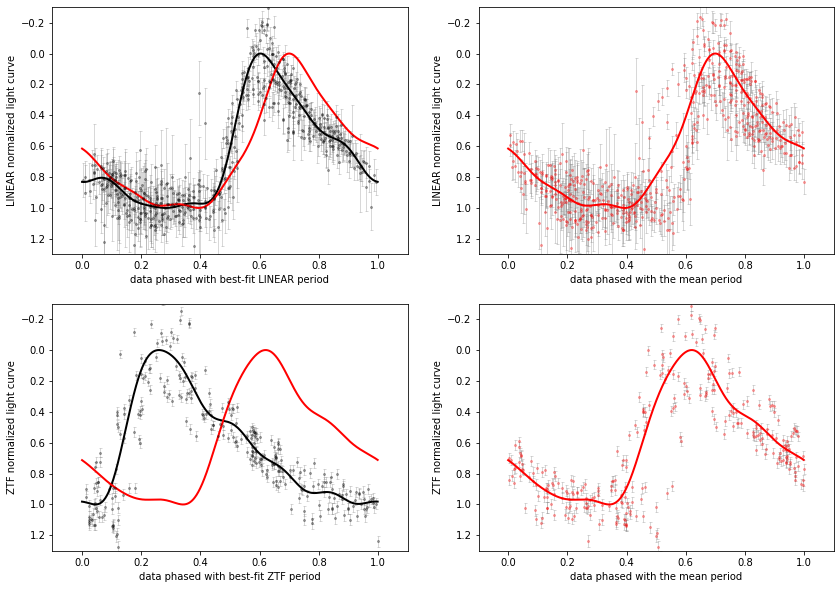

In [32]:
# id0 = '24107664'
# id0 = '10022663'
#id0 = '104455'
# id0 = '18525697'
id0 = '1092244'   # Blazhko star
Pcomparison = {}
Pcomparison[id0], fL, pL, fZ, pZ = compareLINEARvsZTFlightCurves(Lrrlyr, LINEARlightcurves, id0)
## here needs code to store (fL, pL) and (fZ, pZ) to two files...

In [33]:
Pcomparison[id0]

{'LINEARid': '1092244',
 'Plinear': 0.6494951654735606,
 'Pztf': 0.649556986620603,
 'Pratio': 1.000095183382924,
 'NdataLINEAR': 590,
 'LPlin_rmsdmag': 0.1052893518009241,
 'LPlin_chi2dof': 2.3236681011883444,
 'LPlin_chi2dofR': 1.1614976528732004,
 'LPmean_rmsdmag': 0.155418668407492,
 'LPmean_chi2dof': 5.083303715627593,
 'LPmean_chi2dofR': 1.6844569796296516,
 'Lmmax': 16.090303673915507,
 'Lampl': 0.7228091474734768,
 'NdataZTF': 295,
 'ZPztf_rmsdmag': 0.1289455177816566,
 'ZPztf_chi2dof': 37.37436125041806,
 'ZPztf_chi2dofR': 4.011416613595154,
 'ZPmean_rmsdmag': 0.1583467389168599,
 'ZPmean_chi2dof': 50.699926536072724,
 'ZPmean_chi2dofR': 4.9620132949070825,
 'Zmmax': 16.151010331138288,
 'Zampl': 0.5688062848783488}

In [53]:
## a little helper for storing Lomb-Scargle periodogram
def writeLSperiodogram(freq, power, filename):
    print('writeLSperiodogram is not finished')

------------------------------------------------------------
Period and light curve analysis for LINEAR ID = 95250
  computing LINEAR period...
  computing ZTF period...
Plinear= 0.3138703599420054 Pztf= 0.31387651158819085 Pmean= 0.31387343576509813 Pratio= 1.000019599321792
 LINEAR light curve analysis:
  Nlinear= 222 rms mag D-M: 0.16204022148417943 0.16620846789929244
      chi2dof: 0.8165901238617939 0.9107957616519559
       robust: 0.8596163152376052 0.8669305613306125
 ZTF light curve analysis:
  Nztf= 835 rms mag D-M: 0.0468676977297567 0.05493205110114721
      chi2dof: 2.8810644244861225 3.7705705257296143
       robust: 1.3401589118181163 1.537247146619988


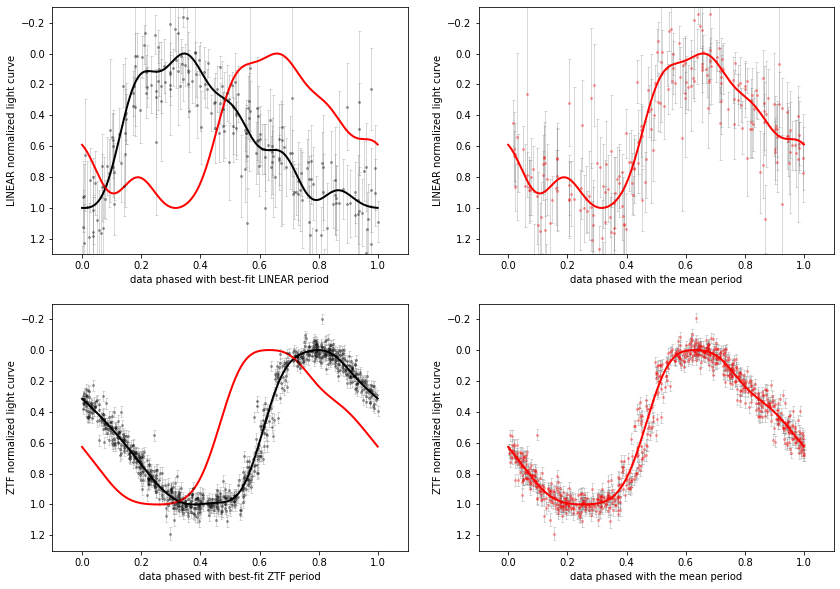

------------------------------------------------------------
Period and light curve analysis for LINEAR ID = 172382
  computing LINEAR period...
  computing ZTF period...
Plinear= 0.4583088933795728 Pztf= 0.4583074373775919 Pmean= 0.4583081653785823 Pratio= 0.9999968230990016
 LINEAR light curve analysis:
  Nlinear= 227 rms mag D-M: 0.06019006052644541 0.06086766929446925
      chi2dof: 1.4925071493051147 1.597738425707002
       robust: 1.0842384994479148 1.1044714091998695
 ZTF light curve analysis:
  Nztf= 1378 rms mag D-M: 0.02682972506588424 0.027387279756270005
      chi2dof: 8.921957695303092 9.084018108018537
       robust: 2.3473505653352373 2.434363218435186


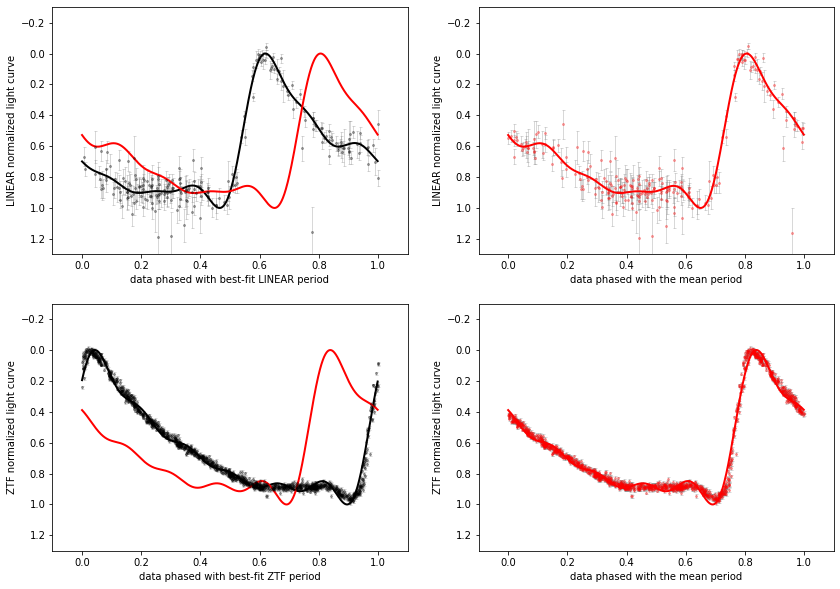

------------------------------------------------------------
Period and light curve analysis for LINEAR ID = 976746
  computing LINEAR period...
  computing ZTF period...
Plinear= 0.6206726397475952 Pztf= 0.6206610733609326 Pmean= 0.6206668565542639 Pratio= 0.9999813647550706
 LINEAR light curve analysis:
  Nlinear= 236 rms mag D-M: 0.09384390119488879 0.0894731765290782
      chi2dof: 3.8782630521932897 4.0133950082817345
       robust: 1.6236876666900713 1.6043244877675482
 ZTF light curve analysis:
  Nztf= 635 rms mag D-M: 0.06369735746181217 0.061026212632524945
      chi2dof: 4.078636331765209 4.17787612739504
       robust: 1.9710064020606566 1.8891410461093054


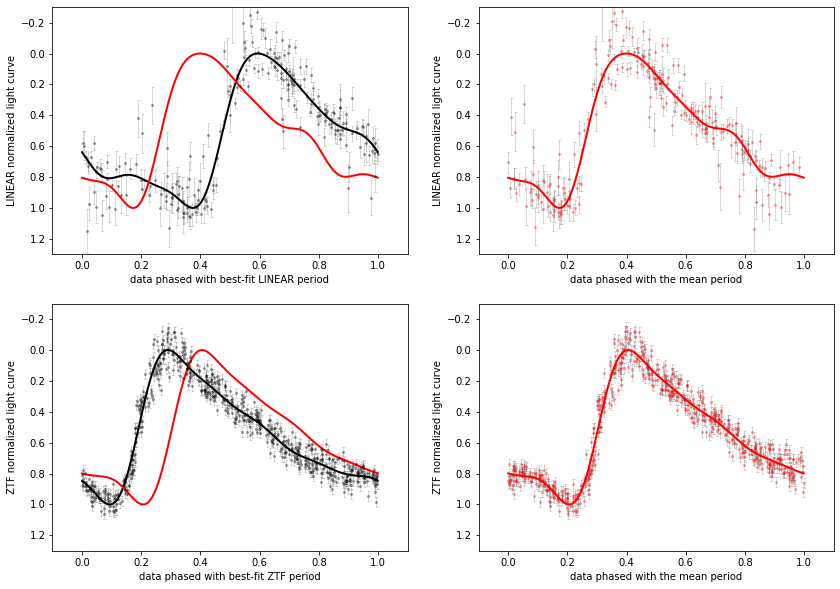

------------------------------------------------------------
Period and light curve analysis for LINEAR ID = 1092244
  computing LINEAR period...
  computing ZTF period...
Plinear= 0.6494951654735606 Pztf= 0.649556986620603 Pmean= 0.6495260760470818 Pratio= 1.000095183382924
 LINEAR light curve analysis:
  Nlinear= 590 rms mag D-M: 0.1052893518009241 0.155418668407492
      chi2dof: 2.3236681011883444 5.083303715627593
       robust: 1.1614976528732004 1.6844569796296516
 ZTF light curve analysis:
  Nztf= 295 rms mag D-M: 0.1289455177816566 0.1583467389168599
      chi2dof: 37.37436125041806 50.699926536072724
       robust: 4.011416613595154 4.9620132949070825


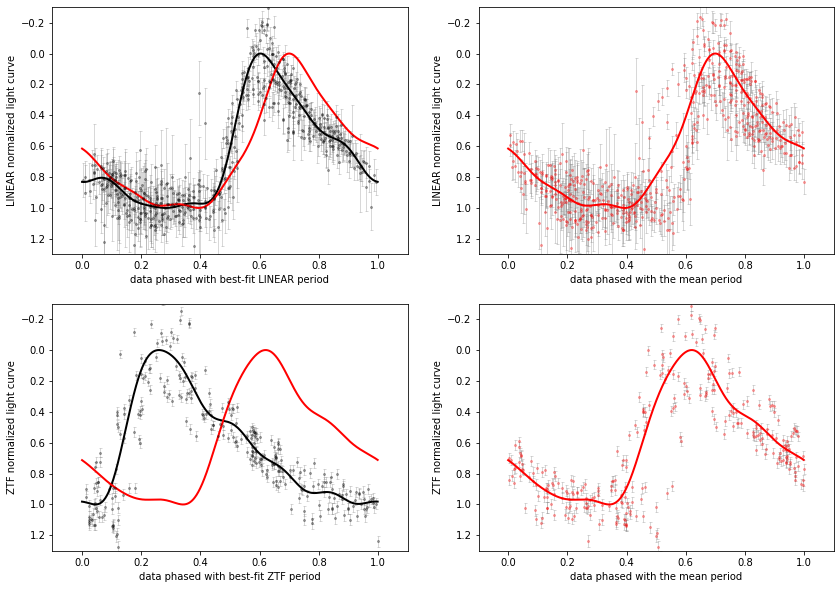

In [34]:
# let's check the four stars sent by Ema:
## Ema's stars;
# Prat=0.6-0.7:
# id0 = '95250'      # Pmean is ok 
# id0 = '172382'     # Pmean is ok, 1378 points in zr! 
# Prat=1.3-1.4:
# id0 = '976746'    # Pmean= 0.620667 fits well both datasets 
# id0 = '1092244'   # noisy ZTF phased curve: possibly Blazhko? 
emaStars = ['95250', '172382', '976746', '1092244']
for id0 in emaStars:
    Pcomparison[id0], fL, pL, fZ, pZ  = compareLINEARvsZTFlightCurves(Lrrlyr, LINEARlightcurves, id0)
    ## here we store (fL, pL) and (fZ, pZ) to two files...
    filename = '../output/LSpower_LINEAR_id' + id0 + '.dat'
    writeLSperiodogram(fL, pL, filename)
    filename = '../output/LSpower_ZTF_id' + id0 + '.dat'
    writeLSperiodogram(fZ, pZ, filename)

In [57]:
## this is a little table for illustration but we really need to store all the values
## in Pcomparison to a file (for later perusal)
for id0 in emaStars:
    print('LINEAR ID=', id0)
    print('    N data:  L=', Pcomparison[id0]['NdataLINEAR'], 'Z=', Pcomparison[id0]['NdataZTF'])
    print(' brightest m:  L=', Pcomparison[id0]['Lmmax'], 'Z=', Pcomparison[id0]['Zmmax'])
    print('      dm rms:  L=', Pcomparison[id0]['LPlin_rmsdmag'], 'Z=', Pcomparison[id0]['ZPztf_rmsdmag'])
    print('  best Rchi2:  L=', Pcomparison[id0]['LPlin_chi2dofR'], 'Z=', Pcomparison[id0]['ZPztf_chi2dofR'])
    print('   best chi2:  L=', Pcomparison[id0]['LPlin_chi2dof'], 'Z=', Pcomparison[id0]['ZPztf_chi2dof'])
    print('   mean chi2:  L=', Pcomparison[id0]['LPmean_chi2dofR'], 'Z=', Pcomparison[id0]['ZPmean_chi2dofR'])
    print('   amplitude:  L=', Pcomparison[id0]['Lampl'], 'Z=', Pcomparison[id0]['Zampl'])
    print('     P ratio: ', Pcomparison[id0]['Pratio'], 'Plinear:', Pcomparison[id0]['Plinear'])

LINEAR ID= 95250
    N data:  L= 222 Z= 835
 brightest m:  L= 16.709858631338257 Z= 16.680121663750146
      dm rms:  L= 0.16204022148417943 Z= 0.0468676977297567
  best Rchi2:  L= 0.8596163152376052 Z= 1.3401589118181163
   best chi2:  L= 0.8165901238617939 Z= 2.8810644244861225
   mean chi2:  L= 0.8669305613306125 Z= 1.537247146619988
   amplitude:  L= 0.4836452846510291 Z= 0.4616602065998805
     P ratio:  1.000019599321792 Plinear: 0.3138703599420054
LINEAR ID= 172382
    N data:  L= 227 Z= 1378
 brightest m:  L= 15.489297399958447 Z= 15.52303011889178
      dm rms:  L= 0.06019006052644541 Z= 0.02682972506588424
  best Rchi2:  L= 1.0842384994479148 Z= 2.3473505653352373
   best chi2:  L= 1.4925071493051147 Z= 8.921957695303092
   mean chi2:  L= 1.1044714091998695 Z= 2.434363218435186
   amplitude:  L= 1.154694323377134 Z= 1.0980245854142243
     P ratio:  0.9999968230990016 Plinear: 0.4583088933795728
LINEAR ID= 976746
    N data:  L= 236 Z= 635
 brightest m:  L= 14.967218311889889

In [36]:
## sample for Blazhko analysis
Lab = Lrrlyr[(Lrrlyr['LCtype']==1)]
len(Lab)

2144

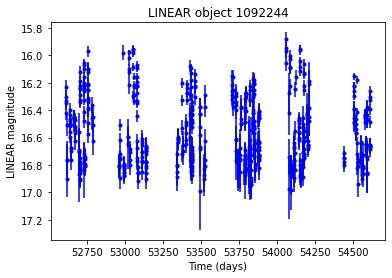

In [37]:
# plot LINEAR light curve
tL, mL, mLerr = LINEARlightcurves[id0].T
fig, ax = plt.subplots()
ax.errorbar(tL, mL, mLerr, fmt='.b', ecolor='blue')
ax.set(xlabel='Time (days)', ylabel='LINEAR magnitude',
       title='LINEAR object {0}'.format(id0))
ax.invert_yaxis()

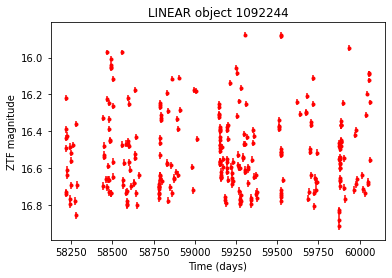

In [38]:
# plot ZTF light curve
ra, dec = getCoordinatesFromLINEARid(Lrrlyr, id0)
ZTFdata = getZTFlightcurve(ra, dec)
BandData = ZTFdata.loc[ZTFdata['filtercode'] == 'zr']
timeZ = BandData['mjd']
magZ = BandData['mag']
magErrZ = BandData['magerr'] 
fig, ax = plt.subplots()
ax.errorbar(timeZ, magZ, magErrZ, fmt='.r', ecolor='red')
ax.set(xlabel='Time (days)', ylabel='ZTF magnitude',
       title='LINEAR object {0}'.format(id0))
ax.invert_yaxis()

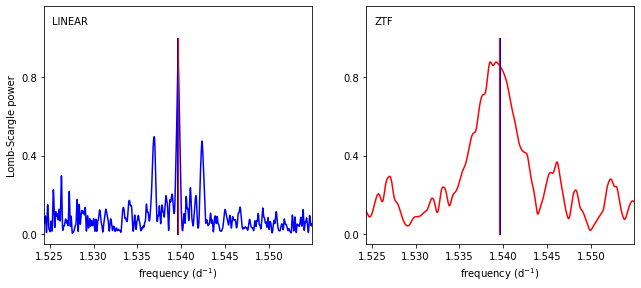

In [58]:
## at some point, we will read periodograms back from files...
fig = plt.figure(figsize=(10, 12))
fig.subplots_adjust(hspace=0.1, bottom=0.06, top=0.94, left=0.12, right=0.94)

flin = 1/Pcomparison[id0]['Plinear']
fztf = 1/Pcomparison[id0]['Pztf']
fmean = (flin+fztf)/2
for i in range(2):
    # plot the power spectrum
    ax = fig.add_subplot(321 + i)
    
    if (i==0):
        ax.plot(fL, pL, c='b')
        ax.plot([flin, flin], [0,1], lw = 1, c='r')
        ax.plot([fmean, fmean], [0,1], lw = 1, c='b')
        ax.text(0.03, 0.96, "LINEAR", ha='left', va='top', transform=ax.transAxes)

    if (i==1):
        ax.plot(fZ, pZ, c='red')
        ax.plot([fztf, fztf], [0,1], lw = 1, c='r')
        ax.plot([fmean, fmean], [0,1], lw = 1, c='b')
        ax.text(0.03, 0.96, "ZTF", ha='left', va='top', transform=ax.transAxes)

    fac = 1.01
    ax.set_xlim(fmean/fac, fmean*fac)
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))
    if i % 2 == 0:
        ax.set_ylabel('Lomb-Scargle power')
        
    if i in (0, 1, 4, 5):
        ax.set_xlabel('frequency (d$^{-1}$)')

plt.show()

In [56]:
## and we need to develop an algorithm and code to recognize the symmetric 3-peak structure 
## as in the left panel... we should probably fold it around the main maximum and then multiply 
## the two branches to boost features symmetric with respect to the main maximum... 